# SWB Regression Pipeline - Alpha Power 
Created: 07/30/24 \
Updated: 08/22/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [12]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
band = 'alpha'
alpha_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
alpha_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [10]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
    roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [13]:
# ####### NEW DATA FRAME 
alpha_reg_df = alpha_df.copy()
alpha_reg_df = alpha_reg_df[alpha_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [14]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(alpha_reg_df,reg_formula,
                                                            elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3436.73it/s]


In [15]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [16]:
results = single_elec_permutation_results(results_dict,alpha_reg_df,save_vars)
results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.012780,-0.026605,0.052417,-0.012949,-0.006266,0.000927,...,0.037352,0.036180,0.717333,-0.717333,1.391779,-0.376098,0.473168,0.473168,0.163989,0.706844
1,MS002_lacas2-lacas3,MS002,acc,14,-0.067714,0.084614,-0.056093,0.028729,-0.009087,-0.000134,...,0.036671,0.035674,-2.148334,2.148334,-1.494622,0.783284,0.031687,0.031687,0.135013,0.433461
2,MS002_lacas3-lacas4,MS002,acc,14,-0.031361,0.033524,0.031966,0.024653,-0.008688,0.000749,...,0.032591,0.034176,-0.905625,0.905625,0.984282,0.730678,0.365134,0.365134,0.324977,0.464976
3,MS002_lacas4-lacas5,MS002,acc,14,-0.068759,0.066715,-0.007873,0.011879,-0.023633,0.001483,...,0.033513,0.032546,-1.794615,1.794615,-0.266610,0.355963,0.072715,0.072715,0.789769,0.721869
4,MS002_lacas5-lacas6,MS002,acc,14,-0.047313,0.076086,0.014755,-0.024627,0.005900,-0.000836,...,0.038045,0.039893,-1.855513,1.855513,0.395845,-0.602774,0.063523,0.063523,0.692219,0.546659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DA039_rpins6-rpins7,DA039,stg,22,-0.013079,0.084468,-0.063193,0.023332,0.020458,-0.003020,...,0.053580,0.054663,-1.625646,1.625646,-1.168907,0.472616,0.104025,0.104025,0.242441,0.636487
1616,DA039_rpins7-rpins8,DA039,stg,22,0.059999,-0.052535,-0.046571,0.033730,0.040785,-0.002411,...,0.075030,0.078564,0.657430,-0.657430,-0.574989,0.390860,0.510905,0.510905,0.565299,0.695901
1617,DA039_rpins8-rpins9,DA039,stg,22,0.062934,-0.084608,-0.018764,0.040773,0.029333,0.003047,...,0.072919,0.073806,1.240000,-1.240000,-0.278970,0.525195,0.214975,0.214975,0.780268,0.599448
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.092241,0.011030,-0.080771,-0.017598,-0.087630,-0.000998,...,0.050877,0.047929,-0.247401,0.247401,-1.572520,-0.371746,0.804598,0.804598,0.115830,0.710082


In [17]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))




In [18]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
30,MS002_lhplt9-lhplt10,MS002,sts,14,-0.185352,0.091750,0.152860,-0.125596,-0.120080,-0.002604,...,0.059764,0.060879,-1.486368,1.486368,2.572229,-2.093290,0.137182,0.137182,0.010105,0.036323
41,MS002_lmoif9-lmoif10,MS002,vlpfc,14,-0.070548,0.051540,-0.024020,0.119478,-0.033359,-0.002219,...,0.057952,0.056841,-0.869997,0.869997,-0.385776,2.097448,0.384302,0.384302,0.699663,0.035954
43,MS002_lmoif11-lmoif12,MS002,vlpfc,14,-0.173279,0.087128,-0.040924,0.122293,-0.111802,-0.001741,...,0.054212,0.053076,-1.554960,1.554960,-0.772687,2.264027,0.119956,0.119956,0.439708,0.023572
61,MS002_racas12-racas13,MS002,dmpfc,14,-0.030530,0.029977,0.032262,0.141826,-0.010657,0.001250,...,0.040800,0.040574,-0.655746,0.655746,0.806043,3.479037,0.511988,0.511988,0.420218,0.000503
73,MS002_raims10-raims11,MS002,dlpfc,14,-0.036266,0.074308,-0.003368,0.129898,0.014737,0.000581,...,0.050608,0.053178,-1.356186,1.356186,-0.089618,2.392041,0.175040,0.175040,0.928591,0.016755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,DA037_ram2-ram3,DA037,amy,4,0.136800,-0.404420,0.055799,0.263570,0.042742,-0.004675,...,0.097139,0.093100,3.518399,-3.518399,0.528999,2.831384,0.000434,0.000434,0.596806,0.004635
1551,DA037_rhh6-rhh7,DA037,mtg,4,0.084203,-0.461641,0.135613,0.292786,-0.023932,-0.002065,...,0.085804,0.086034,4.634426,-4.634426,1.534019,3.469527,0.000004,0.000004,0.125025,0.000521
1552,DA037_rhh7-rhh8,DA037,mtg,4,0.015665,-0.341053,0.110596,0.256104,-0.064730,0.000625,...,0.098534,0.098053,2.911484,-2.911484,1.149436,2.604574,0.003597,0.003597,0.250376,0.009199
1602,DA039_rof4-rof5,DA039,ofc,22,-0.212016,0.022676,0.048190,-0.111874,-0.202556,-0.002000,...,0.049592,0.050550,-0.468288,0.468288,0.987781,-2.174187,0.639578,0.639578,0.323260,0.029691


In [19]:
sig_data.roi.value_counts()



dmpfc       19
ofc         12
sts         11
dlpfc       10
hpc          9
vlpfc        8
mtg          8
stg          8
acc          6
amy          6
smg          5
ains         4
pins         3
thalamus     3
Name: roi, dtype: int64

In [20]:
sig_data.roi.unique()



array(['sts', 'vlpfc', 'dmpfc', 'dlpfc', 'amy', 'ains', 'hpc', 'pins',
       'stg', 'acc', 'ofc', 'mtg', 'thalamus', 'smg'], dtype=object)

In [21]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


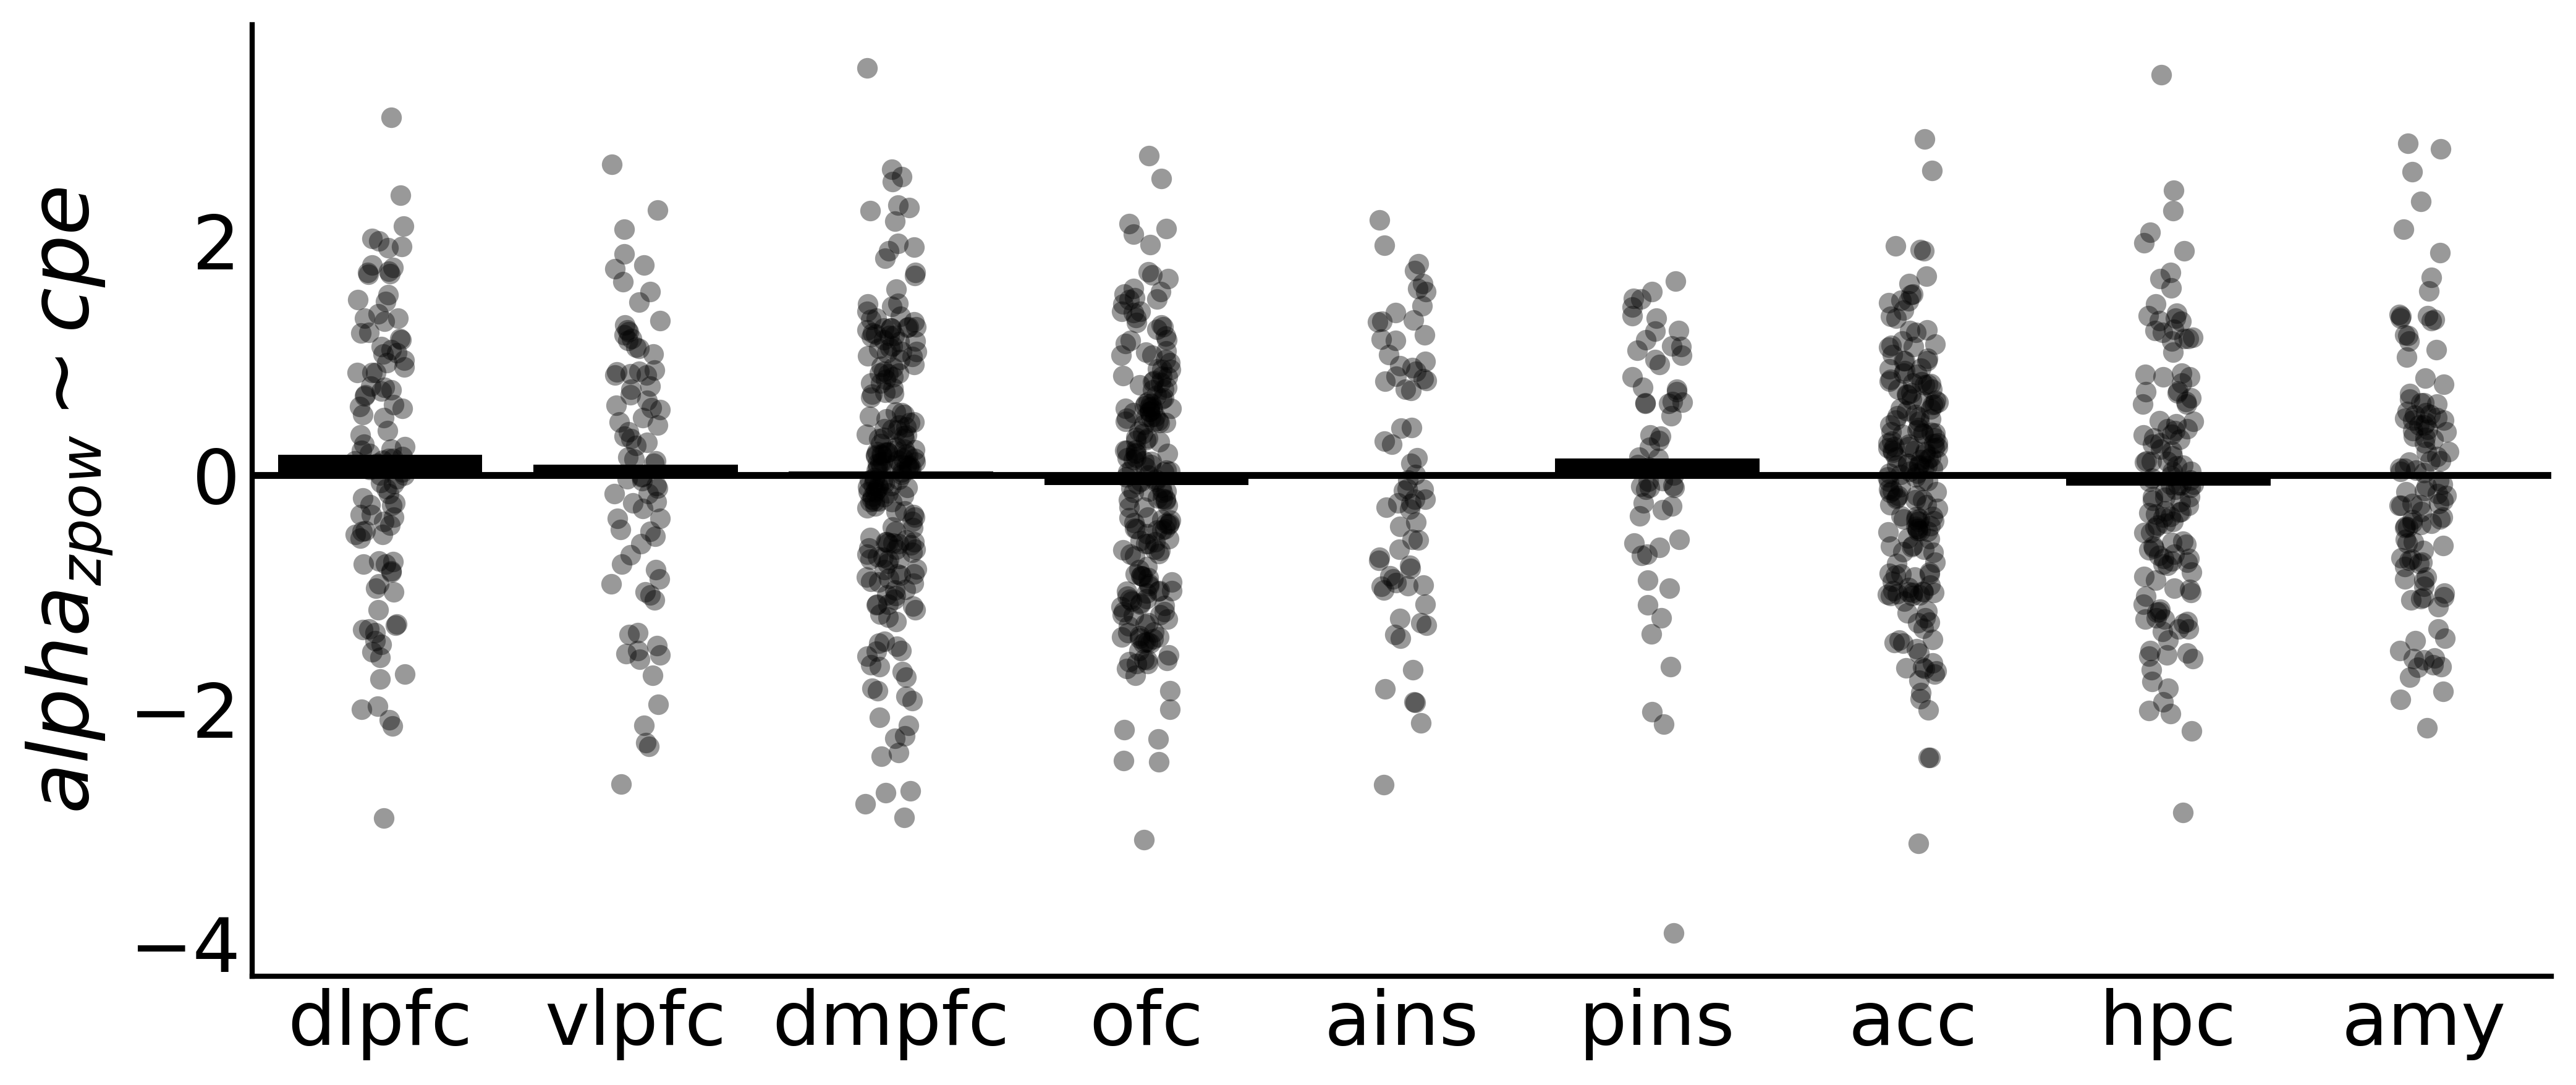

In [22]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='k')
# green '#135546'

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'

plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_dir,fig_id=fig_id,dpi=400)





In [28]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')

In [29]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]



roi
dlpfc    0.173367
vlpfc    0.090247
dmpfc    0.030249
ofc     -0.085756
ains     0.001604
pins     0.138678
acc     -0.034162
hpc     -0.089689
amy     -0.013534
Name: Z_Score_decisionCPE, dtype: float64

In [30]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.012780,-0.026605,0.052417,-0.012949,-0.006266,0.000927,...,0.037352,0.036180,0.717333,-0.717333,1.391779,-0.376098,0.473168,0.473168,0.163989,0.706844
1,MS002_lacas2-lacas3,MS002,acc,14,-0.067714,0.084614,-0.056093,0.028729,-0.009087,-0.000134,...,0.036671,0.035674,-2.148334,2.148334,-1.494622,0.783284,0.031687,0.031687,0.135013,0.433461
2,MS002_lacas3-lacas4,MS002,acc,14,-0.031361,0.033524,0.031966,0.024653,-0.008688,0.000749,...,0.032591,0.034176,-0.905625,0.905625,0.984282,0.730678,0.365134,0.365134,0.324977,0.464976
3,MS002_lacas4-lacas5,MS002,acc,14,-0.068759,0.066715,-0.007873,0.011879,-0.023633,0.001483,...,0.033513,0.032546,-1.794615,1.794615,-0.266610,0.355963,0.072715,0.072715,0.789769,0.721869
4,MS002_lacas5-lacas6,MS002,acc,14,-0.047313,0.076086,0.014755,-0.024627,0.005900,-0.000836,...,0.038045,0.039893,-1.855513,1.855513,0.395845,-0.602774,0.063523,0.063523,0.692219,0.546659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,DA039_rpins1-rpins2,DA039,pins,22,0.034554,0.002238,-0.098905,0.068511,0.035589,-0.000462,...,0.056550,0.056328,-0.045620,0.045620,-1.750294,1.231566,0.963613,0.963613,0.080068,0.218111
1611,DA039_rpins2-rpins3,DA039,pins,22,0.002825,0.068279,-0.065671,0.019040,0.029336,-0.000880,...,0.057947,0.055720,-1.167414,1.167414,-1.153705,0.331936,0.243043,0.243043,0.248621,0.739938
1612,DA039_rpins3-rpins4,DA039,pins,22,-0.040209,0.016750,-0.075655,0.041409,-0.034254,0.001215,...,0.070042,0.067909,-0.219772,0.219772,-1.093954,0.610404,0.826049,0.826049,0.273975,0.541594
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.092241,0.011030,-0.080771,-0.017598,-0.087630,-0.000998,...,0.050877,0.047929,-0.247401,0.247401,-1.572520,-0.371746,0.804598,0.804598,0.115830,0.710082


In [31]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [32]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,-0.034162
ains,0.001604
amy,-0.013534
dlpfc,0.173367
dmpfc,0.030249
hpc,-0.089689
ofc,-0.085756
pins,0.138678
vlpfc,0.090247


In [33]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]



,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,-0.034162,-0.009181,0.8992
dmpfc,0.030249,0.076997,0.2599
amy,-0.013534,-0.016377,0.8633
ains,0.001604,-0.007313,0.9517
vlpfc,0.090247,-0.168392,0.1305
hpc,-0.089689,-0.089432,0.3023
ofc,-0.085756,-0.137649,0.0508
pins,0.138678,0.024077,0.8551
dlpfc,0.173367,0.111407,0.2533


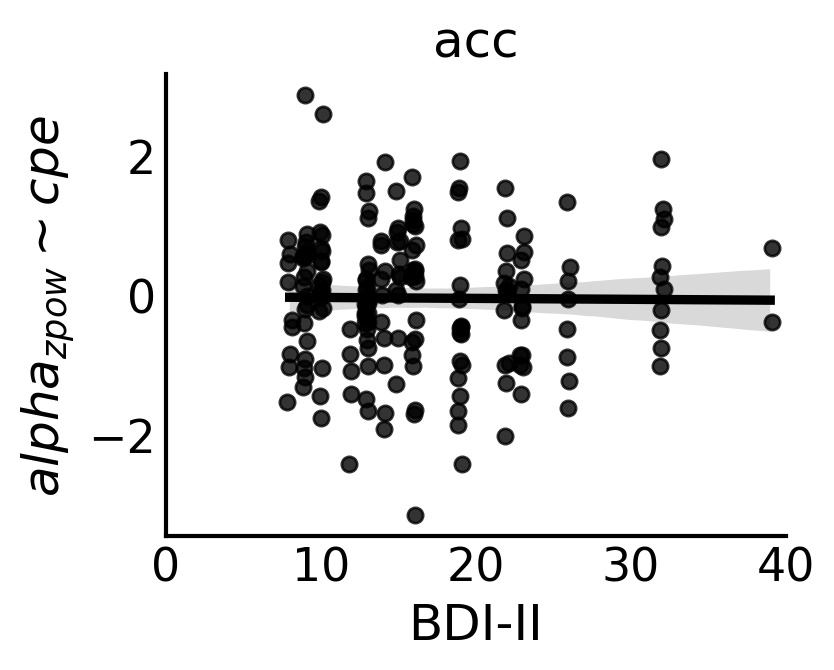

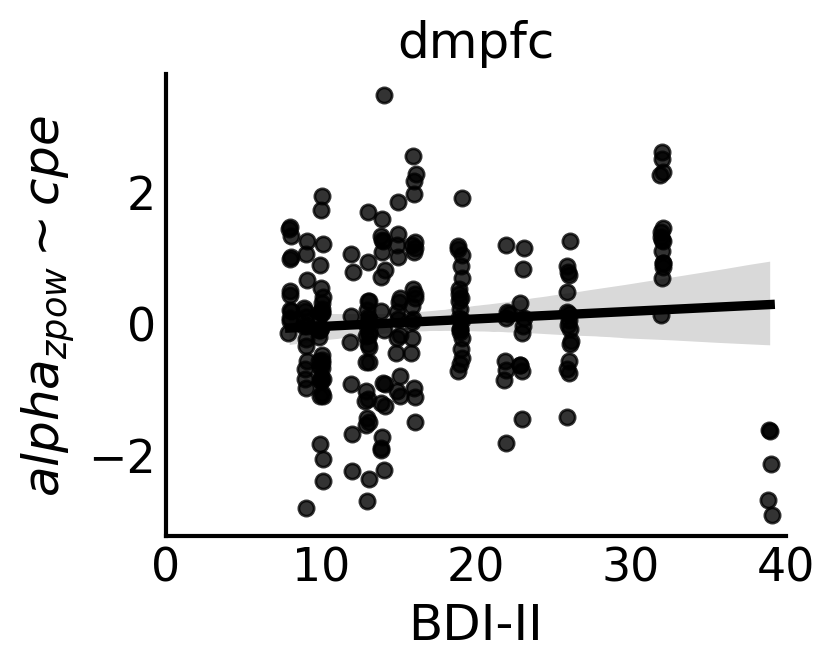

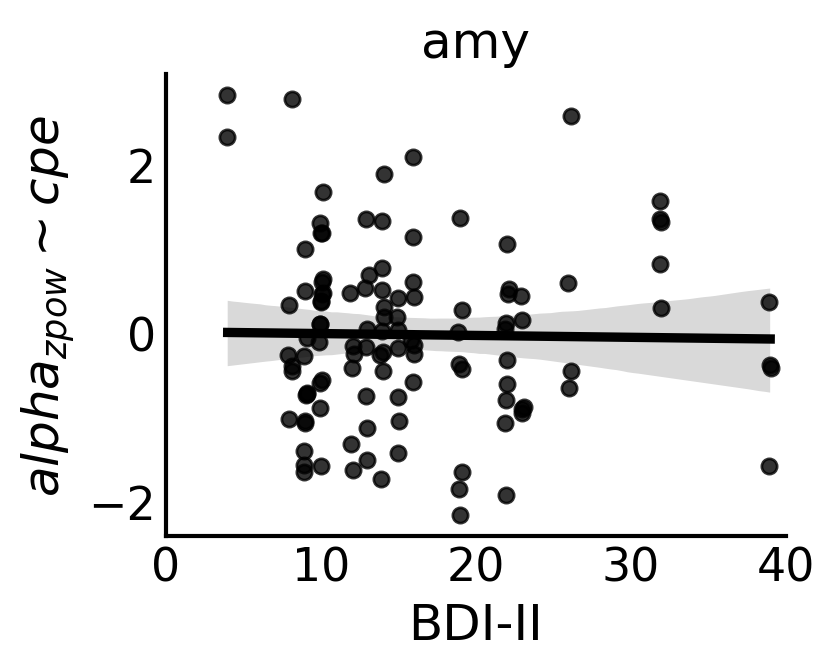

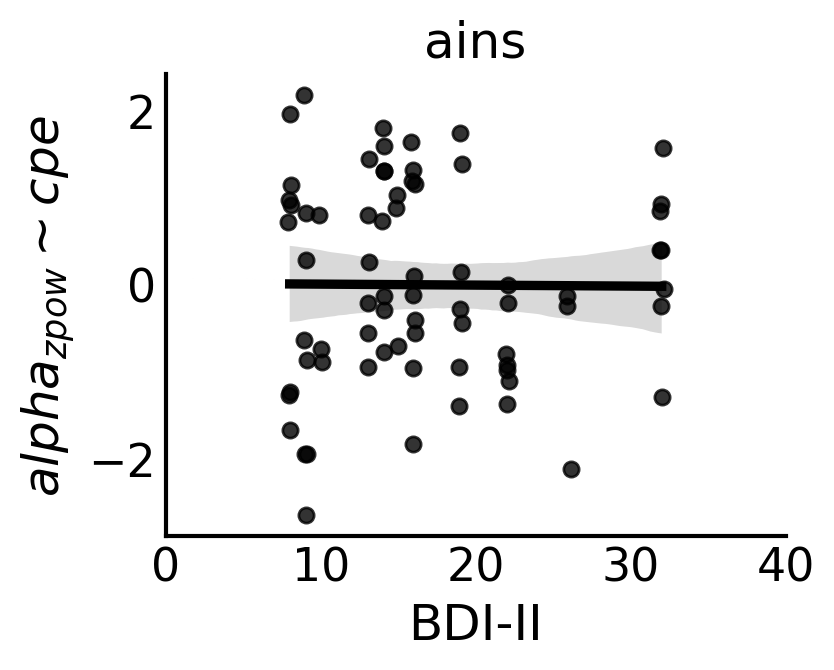

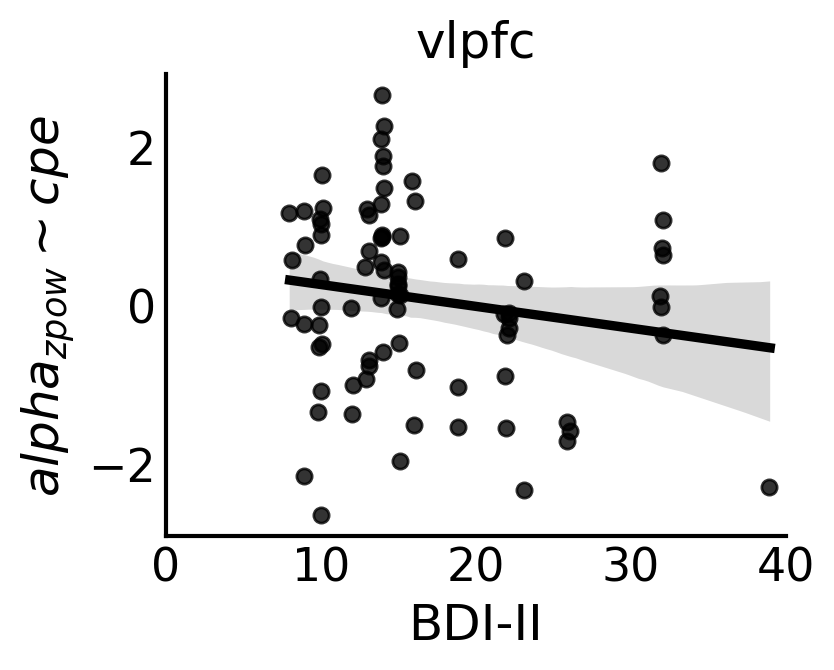

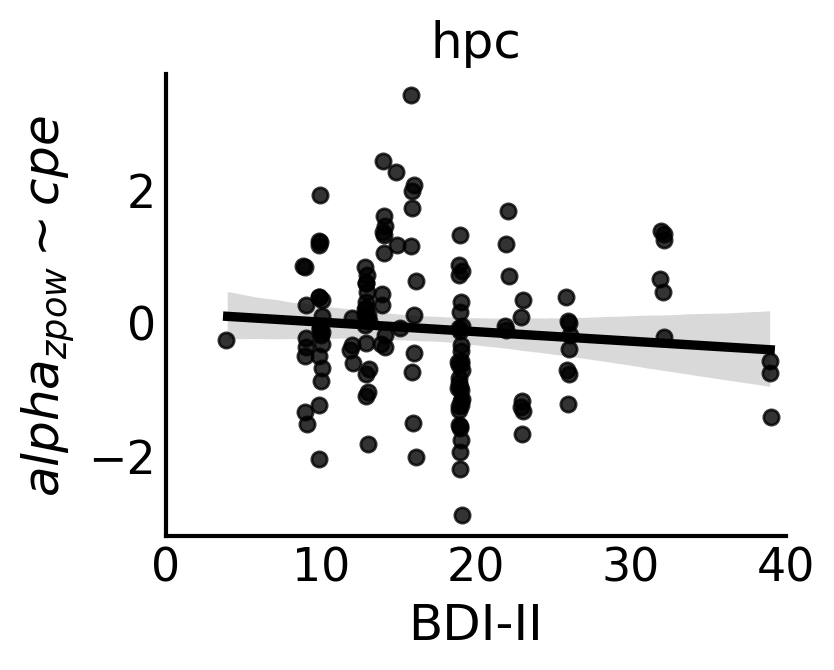

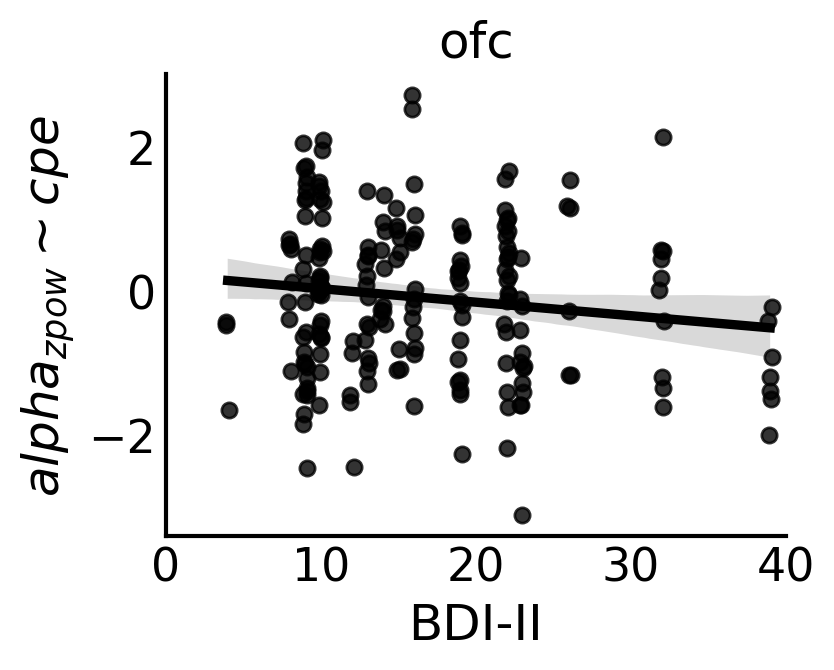

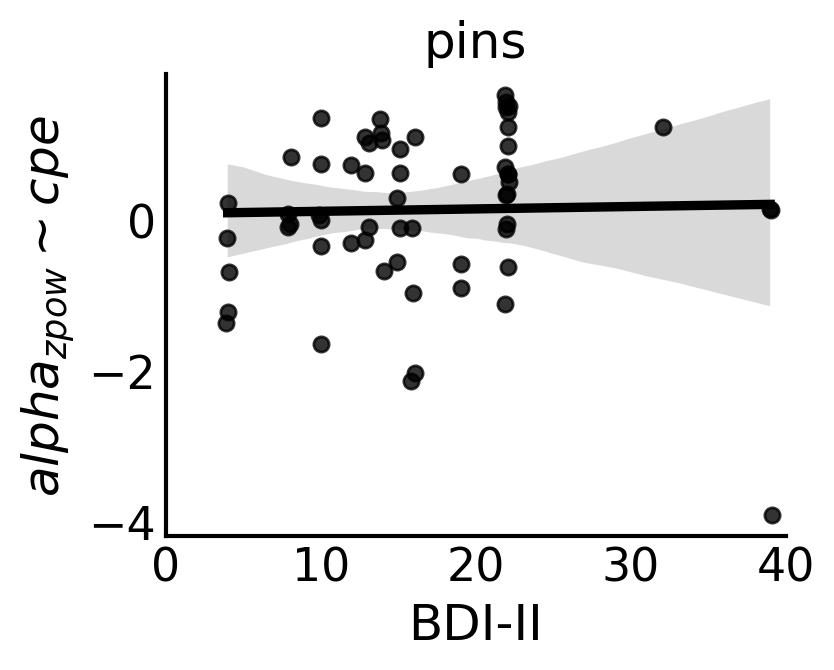

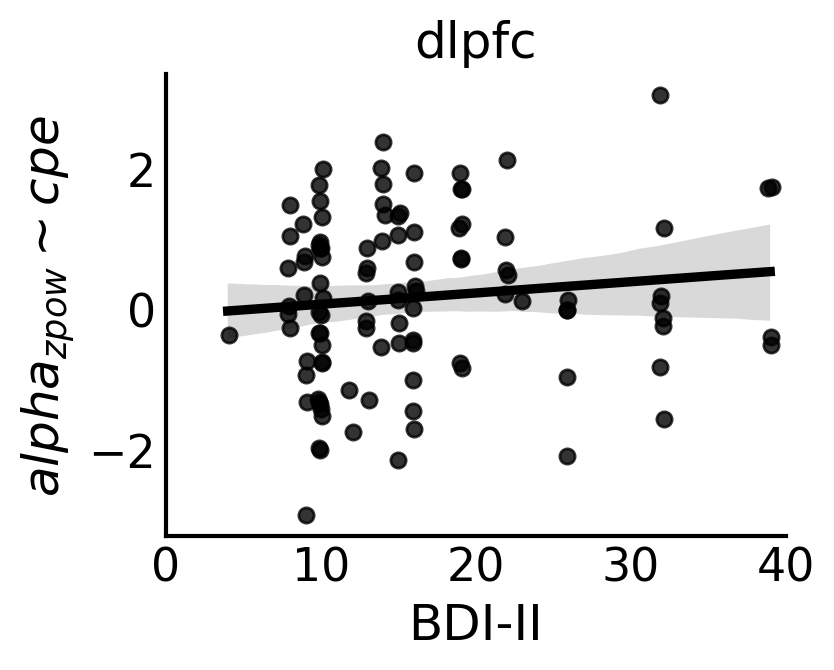

In [34]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [35]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        16:41:42                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8508      0.438     36.205     